## Import Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,f1_score, make_scorer, classification_report, roc_auc_score
import sqlite3
import datetime
import scikitplot as skplt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from gensim.models import Word2Vec

from sklearn.externals.joblib import parallel_backend

import warnings
warnings.filterwarnings('ignore')
global_start = datetime.datetime.now()

## Read Data into Pandas Dataframe

In [52]:
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
conn.close()

print('Shape of our data : {}'.format(data.shape))
data.head(3)    

Shape of our data : (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


## Randomly Sample 100k points from 364k points

In [53]:
sample_data = data.sample(n=100000, random_state=42).reset_index(drop=True)
del data # To free up the RAM
print('shape of our sampled data : {}'.format(sample_data.shape))
print('\n Distribution of class label : \n{}'.format(sample_data['Score'].value_counts(normalize=True)))
sample_data.head(3)

shape of our sampled data : (100000, 11)

 Distribution of class label : 
positive    0.84356
negative    0.15644
Name: Score, dtype: float64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,474309,B003L1XMAA,A2BS25CMKABXK5,"Lela ""Lela""",4,4,positive,1309996800,Delicious,Too busy enjoying this wonderful lavender extr...,busy enjoying wonderful lavender extract homem...
1,474247,B005IU1NLC,A1OTUKJ8298TY5,Elizabeth MccArthy,0,0,positive,1317600000,So yummy,These are sooooo good! I had to find them on h...,sooooo good find since sell single packet supe...
2,343379,B00004RBDU,A28ZA79VMCI8W1,"Linda Khan ""kittykatkhan""",2,2,positive,1257206400,Flea Trap WORKS!,"In the past, I have used a metal type flea tra...",past used metal type flea trap owned operated ...


## Create a feature based on length of the Review

In [54]:
sample_data['word_count'] = sample_data['Text'].apply(lambda x : len(x.split()))
sample_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,word_count
0,474309,B003L1XMAA,A2BS25CMKABXK5,"Lela ""Lela""",4,4,positive,1309996800,Delicious,Too busy enjoying this wonderful lavender extr...,busy enjoying wonderful lavender extract homem...,29
1,474247,B005IU1NLC,A1OTUKJ8298TY5,Elizabeth MccArthy,0,0,positive,1317600000,So yummy,These are sooooo good! I had to find them on h...,sooooo good find since sell single packet supe...,28
2,343379,B00004RBDU,A28ZA79VMCI8W1,"Linda Khan ""kittykatkhan""",2,2,positive,1257206400,Flea Trap WORKS!,"In the past, I have used a metal type flea tra...",past used metal type flea trap owned operated ...,138


## Time Based Splitting
We arrange the sampled data in ascending order of Time column and split the data without shuffling such that:

* Train_data = First 70%
* Test_data = Last 30%

In [55]:
# Sort by Time
sample_data = sample_data.sort_values('Time').reset_index(drop=True)

X_text = sample_data.iloc[:,10] # Selecting the 'CleanedText' column
y = sample_data.iloc[:,6] # Selecting the 'Score' column

# Split the data
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.30, shuffle=False)

# Sanity check
print('Shape of X_text_train : {}'.format(X_text_train.shape))
print('Shape of y_train : {}'.format(y_train.shape))
print()
print('Shape of X_text_test : {}'.format(X_text_test.shape))
print('Shape of y_test : {}'.format(y_test.shape))

Shape of X_text_train : (70000,)
Shape of y_train : (70000,)

Shape of X_text_test : (30000,)
Shape of y_test : (30000,)


## Modelling
We will Create a **Support Vector Machine** based classification model using the following features:

* Binary Bag Of Words 
* Count based Bag Of words 
* TFIDF 
* AVG Word2Vec
* TFIDF weighted Word2Vec

### Create Features
The function below will convert raw text to the designated features

In [56]:
# ********* Create Features for Linear Kernel ******************
def featurize(feature, standardize=True):
    
    if feature == 'binary_bow':
        count_vec = CountVectorizer(binary=True)
        X_train = count_vec.fit_transform(X_text_train)
        X_test = count_vec.transform(X_text_test)
        featurizer = count_vec
       
    if feature == 'bow':
        count_vec = CountVectorizer()
        X_train = count_vec.fit_transform(X_text_train)
        X_test = count_vec.transform(X_text_test)
        featurizer = count_vec
        
    if feature == 'tfidf':
        tfidf_vec = TfidfVectorizer()
        X_train = tfidf_vec.fit_transform(X_text_train)
        X_test = tfidf_vec.transform(X_text_test)
        featurizer = tfidf_vec
       
    if feature == 'w2v':
        X_train, X_test = get_w2v()
        featurizer = None
       
    if feature == 'tfidf_w2v':
        X_train, X_test = get_tfidf_w2v()
        featurizer = None
        
    if standardize:
        scaler = StandardScaler(with_mean=False)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, featurizer 

In [57]:
def get_w2v():
    
    # ******************* Tokenize training reviews ********************
    review_list = []
    for review in X_text_train:
        review_list.append(review.split())
        
    # ****************** Word2Vec **********************
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(review_list,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    
    # *************** Converting training reviews to vectors ********************
    X_train = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                review_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            review_vec /= cnt_words
        X_train.append(review_vec)
    X_train = np.array(X_train)
    
    # ********** Tokenize test reviews *****************
    review_list = []
    for review in X_text_test:
        review_list.append(review.split())
        
    # **************** Converting test reviews to vectors ****************
    X_test = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                review_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            review_vec /= cnt_words
        X_test.append(review_vec)
    X_test = np.array(X_test)
    
    return X_train, X_test

In [58]:
def get_tfidf_w2v():
    
    # ******************* Tokenize training reviews ********************
    review_list = []
    for review in X_text_train:
        review_list.append(review.split())
        
    # ********************** Word2Vec**************************
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(review_list,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)    
    
    # *********************** TF-IDF **************************
    tfidf_vec = TfidfVectorizer()
    tfidf_vec.fit(X_text_train)
    idf_dict = dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_))
    
    # ***************** Converting Training Reviews to vectors *************
    X_train = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                tf_idf = idf_dict[word]*(review.count(word)/len(review))
                review_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            review_vec /= weight_sum
        X_train.append(review_vec)
    X_train = np.array(X_train)
    
    # ********** Tokenize test reviews *****************
    review_list = []
    for review in X_text_test:
        review_list.append(review.split())
       
    # ****************** Converting Test reviews to vectors *************
    X_test = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                tf_idf = idf_dict[word]*(review.count(word)/len(review))
                review_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            review_vec /= weight_sum
        X_test.append(review_vec)
    X_test = np.array(X_test)
   
    return X_train, X_test

### Cross validation and Hyper Parameter turning using GridSearch - Linear SVM

In [59]:
def crossval_linear_svm():
    
    start = datetime.datetime.now()
    
    # Create a SVM object
    clf = SGDClassifier(n_jobs=-1, class_weight='balanced')
    
    # Tune hyper parameters using grid search
    param_dict = {}
    param_dict['alpha'] = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10,20,50]
    model = GridSearchCV(clf, param_grid=param_dict, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=10)
    model.fit(X_train, y_train)
    
    # Plot Hyperparameters v/s AUC score for both train and test data
    params = param_dict['alpha']
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score']
    
    # ****** Code for plotting **********
    plt.figure(figsize=(12,6))
    plt.plot(params, test_scores, '-o', label='Test Scores')
    plt.plot(params, train_scores, '-o', label='Train Scores')
    plt.xlabel('alpha values', fontsize=13)
    plt.ylabel('Weighted F-1 Score', fontsize=13)
    plt.title('Hyperparameter v/s Weighted F-1 Score', fontsize=16)
    plt.grid('on')
    plt.legend(loc='best', fontsize=12)
    plt.show()
    
    print('\nTime taken for cross-validation : {}'.format(datetime.datetime.now() - start))
    print("\nBest model found using cross-validation : {}".format(model.best_estimator_))
    print('\nWeighted F-1 score of the best model using cross-validation : {}'.format(model.best_score_))
    
    weights = model.best_estimator_.fit(X_train, y_train).coef_[0]

    if featurizer is not None:
        positive_weights = weights.argsort()[::-1]
        negative_weights = weights.argsort()

        print('\nTop positive class words :',np.take(featurizer.get_feature_names(), positive_weights[:10]))
        print('\nTop negative class words :',np.take(featurizer.get_feature_names(), negative_weights[:10]))

    return model.best_estimator_
    

### Predictions on Test Data 

In [60]:
def make_predictions(clf):
    calib_clf = CalibratedClassifierCV(clf, cv=2)
    calib_clf.fit(X_train, y_train)
    y_scores = calib_clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    
    print('\n########## CLASSIFICATION REPORTS ON TEST DATA ##########')
    print('\n\taccuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
    print('\tweighted f1-score on test data : {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\tWeighted AUC score on test data : {}'.format(roc_auc_score(y_test, y_scores[:,1], average='weighted')))
    print()
    print(classification_report(y_test, y_pred))
    print()
    print()
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    skplt.metrics.plot_roc(y_test, y_scores)

## Binary Bag of Words + Linear Kernel

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.4s finished


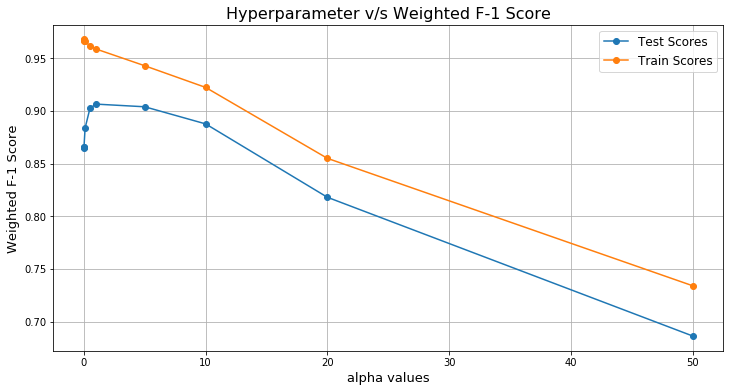


Time taken for cross-validation : 0:00:23.563843

Best model found using cross-validation : SGDClassifier(alpha=1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Weighted F-1 score of the best model using cross-validation : 0.9064105125862822

Top positive class words : ['great' 'best' 'love' 'delicious' 'good' 'loves' 'perfect' 'excellent'
 'favorite' 'nice']

Top negative class words : ['disappointed' 'not' 'worst' 'terrible' 'disappointing' 'awful' 'bad'
 'horrible' 'waste' 'thought']


In [61]:
X_train, X_test, featurizer = featurize('binary_bow')
clf = crossval_linear_svm()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8935
	weighted f1-score on test data : 0.8974163311279951
	Weighted AUC score on test data : 0.9321884217708917

              precision    recall  f1-score   support

    negative       0.66      0.80      0.72      5242
    positive       0.96      0.91      0.93     24758

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.81      0.86      0.83     30000
weighted avg       0.90      0.89      0.90     30000





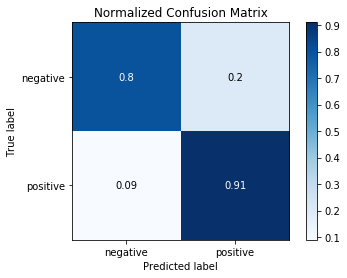

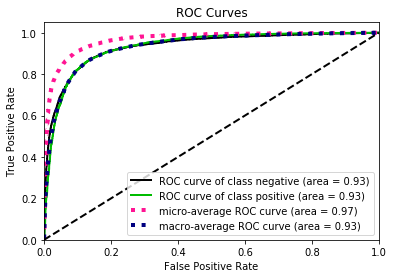

In [62]:
make_predictions(clf)

## Count Based Bag of words + Linear Kernel

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.1s finished


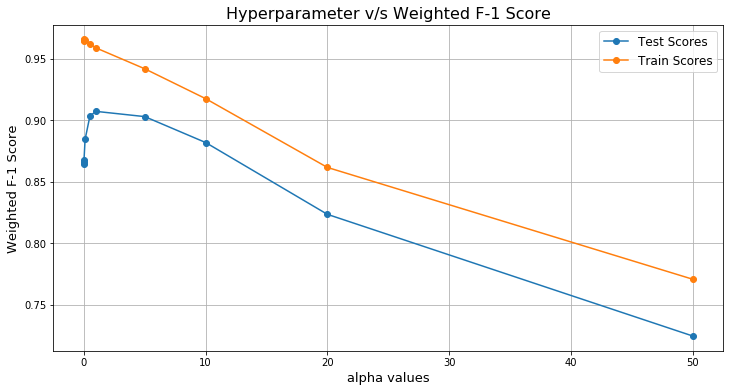


Time taken for cross-validation : 0:00:19.229447

Best model found using cross-validation : SGDClassifier(alpha=1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Weighted F-1 score of the best model using cross-validation : 0.9071715515998979

Top positive class words : ['great' 'best' 'love' 'delicious' 'good' 'loves' 'perfect' 'excellent'
 'favorite' 'wonderful']

Top negative class words : ['disappointed' 'not' 'worst' 'terrible' 'disappointing' 'awful'
 'horrible' 'bad' 'waste' 'stale']


In [63]:
X_train, X_test, featurizer = featurize('bow')
clf = crossval_linear_svm()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8918
	weighted f1-score on test data : 0.8961976569231588
	Weighted AUC score on test data : 0.9302248897908634

              precision    recall  f1-score   support

    negative       0.65      0.81      0.72      5242
    positive       0.96      0.91      0.93     24758

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.81      0.86      0.83     30000
weighted avg       0.90      0.89      0.90     30000





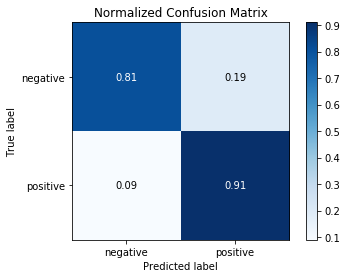

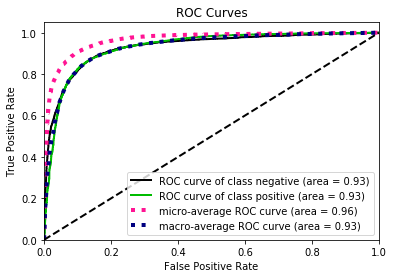

In [64]:
make_predictions(clf)

## TF-IDF + Linear Kernel

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.4s finished


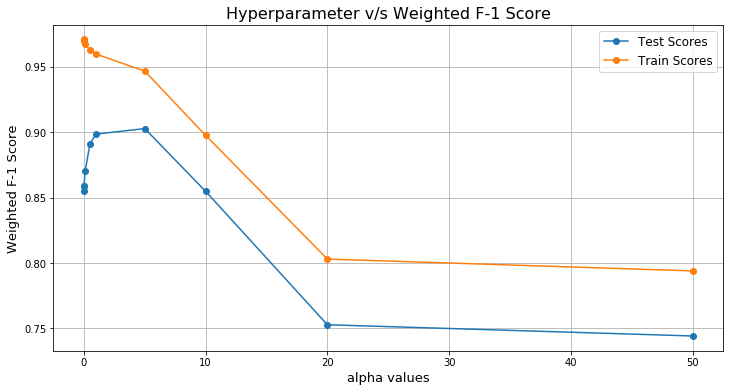


Time taken for cross-validation : 0:00:24.949113

Best model found using cross-validation : SGDClassifier(alpha=5, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Weighted F-1 score of the best model using cross-validation : 0.9026311579592625

Top positive class words : ['great' 'love' 'best' 'delicious' 'good' 'perfect' 'loves' 'favorite'
 'find' 'easy']

Top negative class words : ['not' 'disappointed' 'worst' 'terrible' 'awful' 'disappointing' 'bad'
 'waste' 'horrible' 'disappointment']


In [65]:
X_train, X_test, featurizer = featurize('tfidf')
clf = crossval_linear_svm()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8812666666666666
	weighted f1-score on test data : 0.8865204748510318
	Weighted AUC score on test data : 0.929957262917017

              precision    recall  f1-score   support

    negative       0.63      0.79      0.70      5242
    positive       0.95      0.90      0.93     24758

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.79      0.85      0.81     30000
weighted avg       0.90      0.88      0.89     30000





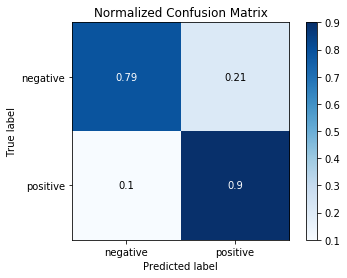

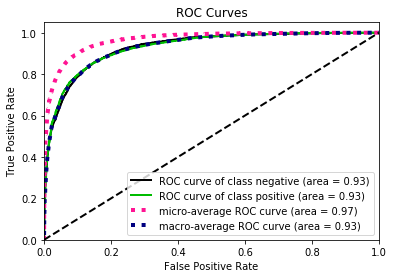

In [66]:
make_predictions(clf)

## AVG Word2Vec + Linear SVM

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.3s finished


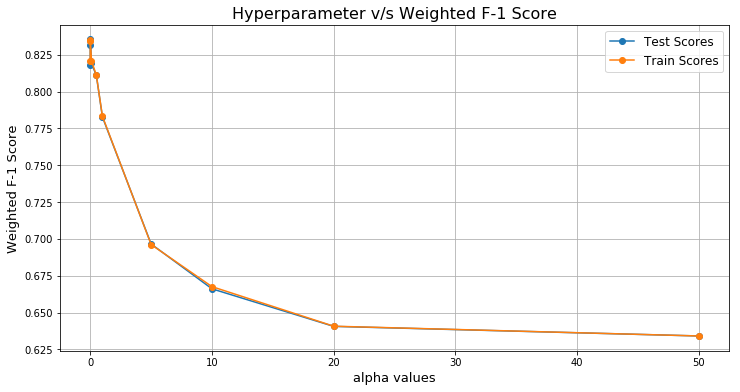


Time taken for cross-validation : 0:00:16.197152

Best model found using cross-validation : SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Weighted F-1 score of the best model using cross-validation : 0.8353703207443672


In [67]:
X_train, X_test, featurizer = featurize('w2v')
clf = crossval_linear_svm()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8059333333333333
	weighted f1-score on test data : 0.8247272828741936
	Weighted AUC score on test data : 0.9047068334179936

              precision    recall  f1-score   support

    negative       0.47      0.85      0.60      5242
    positive       0.96      0.80      0.87     24758

   micro avg       0.81      0.81      0.81     30000
   macro avg       0.72      0.82      0.74     30000
weighted avg       0.87      0.81      0.82     30000





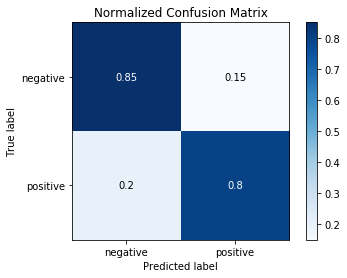

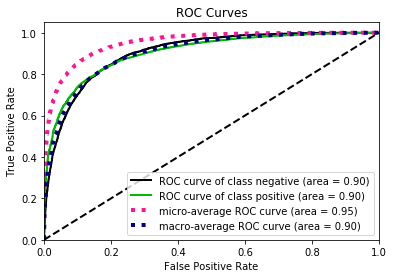

In [68]:
make_predictions(clf)

## TFIDF Weighted Word2Vec + Linear SVM

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.9s finished


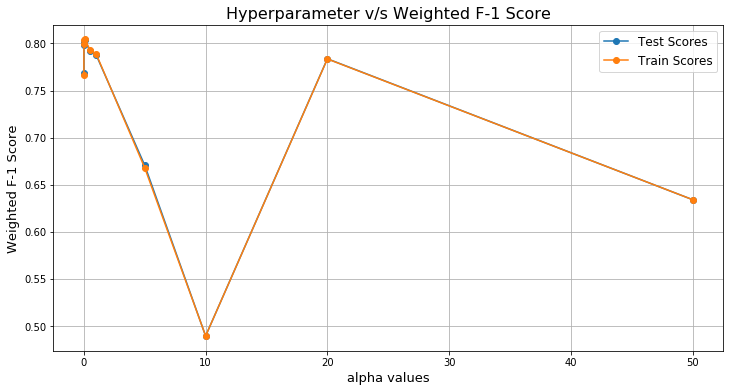


Time taken for cross-validation : 0:00:17.080638

Best model found using cross-validation : SGDClassifier(alpha=0.1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Weighted F-1 score of the best model using cross-validation : 0.8033172875893146


In [69]:
X_train, X_test, featurizer = featurize('tfidf_w2v')
clf = crossval_linear_svm()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.7625666666666666
	weighted f1-score on test data : 0.7883889439300329
	Weighted AUC score on test data : 0.8751573144867961

              precision    recall  f1-score   support

    negative       0.41      0.84      0.55      5242
    positive       0.96      0.75      0.84     24758

   micro avg       0.76      0.76      0.76     30000
   macro avg       0.68      0.79      0.70     30000
weighted avg       0.86      0.76      0.79     30000





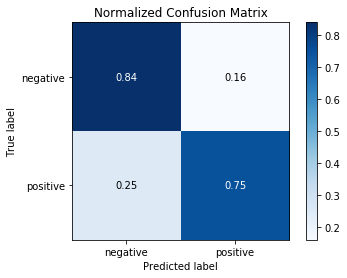

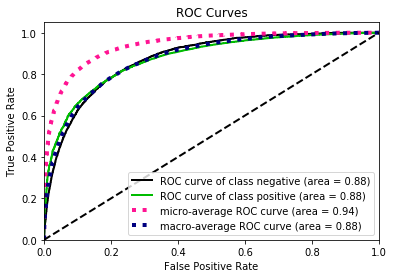

In [70]:
make_predictions(clf)

## Count Based Bag of words + word count + Linear Kernel

In [71]:
# **************** Create train and test data ********************
X_text = sample_data.iloc[:,[10,11]] # Selecting the 'CleanedText' and 'word_count' column.
y = sample_data.iloc[:,6] # Selecting the 'Score' column

# Split the data
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.30, shuffle=False)

# Sanity check
print('Shape of X_text_train : {}'.format(X_text_train.shape))
print('Shape of y_train : {}'.format(y_train.shape))
print()
print('Shape of X_text_test : {}'.format(X_text_test.shape))
print('Shape of y_test : {}'.format(y_test.shape))

# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer()
X_train_bow = count_vec.fit_transform(X_text_train['CleanedText'])
X_test_bow = count_vec.transform(X_text_test['CleanedText'])
print('\nType of X_train_bow : {}'.format(type(X_train_bow)))
print('Shape of X_train_bow : {}'.format(X_train_bow.get_shape()))
print('Shape of X_test_bow : {}'.format(X_test_bow.get_shape()))
print('Number of unique words : {}'.format(X_train_bow.get_shape()[1]))

# Standardise Data
scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_test_bow = scaler.transform(X_test_bow)

# ***************** Adding the length column to CSR Matrix in train data *********
X_train = hstack((X_train_bow,X_text_train['word_count'][:, None]),format='csr')
print('\nShape of X_train : {}'.format(X_train.get_shape()))

# ***************** Adding the length column to CSR Matrix in test data *********
X_test = hstack((X_test_bow,X_text_test['word_count'][:, None]),format='csr')
print('Shape of X_test : {}'.format(X_test.get_shape()))



Shape of X_text_train : (70000, 2)
Shape of y_train : (70000,)

Shape of X_text_test : (30000, 2)
Shape of y_test : (30000,)

Type of X_train_bow : <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train_bow : (70000, 47863)
Shape of X_test_bow : (30000, 47863)
Number of unique words : 47863

Shape of X_train : (70000, 47864)
Shape of X_test : (30000, 47864)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.4s finished


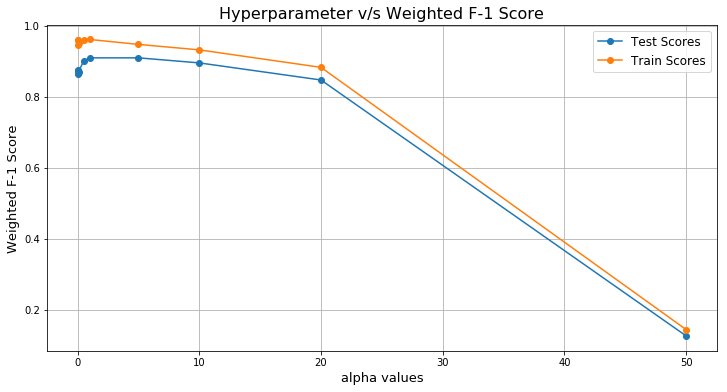


Time taken for cross-validation : 0:00:22.829692

Best model found using cross-validation : SGDClassifier(alpha=5, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Weighted F-1 score of the best model using cross-validation : 0.909789964442204


In [72]:
clf = crossval_linear_svm()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8958
	weighted f1-score on test data : 0.8991895564946707
	Weighted AUC score on test data : 0.9269886488233957

              precision    recall  f1-score   support

    negative       0.67      0.79      0.73      5242
    positive       0.95      0.92      0.94     24758

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.81      0.86      0.83     30000
weighted avg       0.91      0.90      0.90     30000





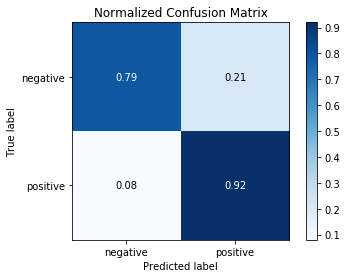

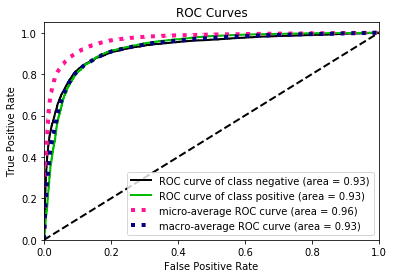

In [73]:
make_predictions(clf)